# Treinando Modelo do Desafio de Detecção de Distração do Motorista

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil, pathlib, glob, sys

IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = os.environ.get('PWD') == '/kaggle/working'

%matplotlib inline
plt.style.use('ggplot')

### Importando o Tensorflow

In [2]:
# importando a biblioteca tensorflow
import tensorflow as tf

# Definindo sementes aleatória  (para facilitar a 
# repetibilidade do código)
tf.random.set_seed(0)
np.random.seed(0)

#verificando a versão do tensorflow
tf.__version__

'2.1.0'

In [3]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
competition_name = 'state-farm-distracted-driver-detection'
root_output_local = f'{competition_name}/model' if not IN_COLAB and not IN_KAGGLE else ''
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/{competition_name}'
api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')

In [4]:
# Montando google drive caso esteja executando no google colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

## Obtendo os dados do desafio

In [5]:
from zipfile import ZipFile

def get_kaggle_json(api_location):
    api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')
    if not os.path.exists(api_local_credential_location):
        !mkdir -p ~/.kaggle
        !cp '{api_location}' '{api_local_credential_location}'

def get_kaggle_data_competition(competition_name, gdrive_kaggle_dir=None):
    if IN_COLAB and not os.path.exists(competition_name):
        gdrive_competition_path = os.path.join(gdrive_kaggle_dir, competition_name)
        if os.path.exists(gdrive_competition_path):
            print('Copiando dados do Google Drive')
            !cp -r '{gdrive_competition_path}' .

    if not os.path.exists(competition_name):
        # Instalação do pacote para acesso a API do Kaggle
        !pip -q install kaggle --upgrade
        # Download dos dados da competição
        !kaggle competitions download -c {competition_name} -p {competition_name}
        if IN_COLAB and os.path.exists(gdrive_kaggle_dir):
            !cp -r {competition_name} '{gdrive_kaggle_dir}'

def extract_files(competition_name):
    if IN_COLAB and os.path.exists(os.path.join(competition_name, f'{competition_name}.zip')):
        with ZipFile(os.path.join(competition_name, f'{competition_name}.zip'), 'r') as zipObj:
            # Extract all the contents of zip file in current directory
            zipObj.extractall(competition_name)
        os.remove(os.path.join(competition_name, f'{competition_name}.zip'))

In [6]:
# Obtem os dados somente se o notebook não esteja sendo executado no Kaggle
if not IN_KAGGLE: 
    get_kaggle_json(api_gdrive_credential_location)
    get_kaggle_data_competition(competition_name, gdrive_kaggle_dir)
    extract_files(competition_name)

In [7]:
pre_dir = '/kaggle/input' if IN_KAGGLE else ''
data_dir = os.path.join(pre_dir, competition_name, 'imgs')
test_dir = f'{data_dir}/test/'
train_dir = f'{data_dir}/train/'

## Analisando Distribuição das Imagens

In [8]:
# Obtendo os diretórios de imagens e a quantidade existente em cada
train_data_dir = pathlib.Path(train_dir)
test_data_dir = pathlib.Path(test_dir)

train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
test_image_count = len(list(test_data_dir.glob('*.jpg')))
print(f'Train size: {train_image_count} | Test size: {test_image_count}')

Train size: 22424 | Test size: 79726


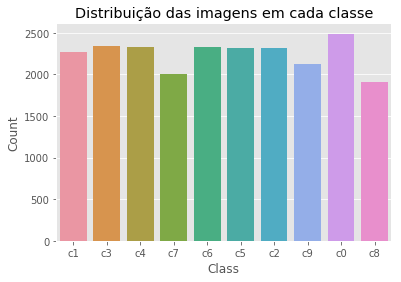

In [9]:
sns.barplot(x='Class', y='Count', data=pd.DataFrame.from_dict(
    {dir: [len(glob.glob(os.path.join(train_data_dir, dir, '*.jpg')))] for dir in os.listdir(train_data_dir)}, 
    orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Class'})).set_title('Distribuição das imagens em cada classe');

## Configurando TPU

In [10]:
# Detectando TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError: # Se Não tiver TPU disponível
    tpu = None
    
# Seleciona estratégia
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Executando na TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
    strategy = tf.distribute.get_strategy() # Estratégia padrão que funciona com GPU ou CPU
    if len(tf.config.experimental.list_physical_devices('GPU')) or len(tf.config.experimental.list_physical_devices('XLA_GPU')):
        print("GPUs Disponíveis: ", len(tf.config.experimental.list_physical_devices('GPU')) + len(tf.config.experimental.list_physical_devices('XLA_GPU')))
    else:
        print('Executando no CPU')
print("Número de Aceleradores: ", strategy.num_replicas_in_sync)

GPUs Disponíveis:  2
Número de Aceleradores:  1


## Configurando DataSets

In [11]:
# Obtendo nomes das classes
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
CLASS_NAMES

array(['c1', 'c3', 'c4', 'c7', 'c6', 'c5', 'c2', 'c9', 'c0', 'c8'],
      dtype='<U2')

In [12]:
# Criando geradores para o pré-processamento
train_valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [13]:
# Definindo parâmetros para o treinamento e processamento das imagens
BATCH_SIZE = 256
if tpu:
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)

In [14]:
# Carregando os geradores com base no caminho para o diretório de imagens
train_data_gen = train_valid_generator.flow_from_directory(
    directory=str(train_data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES),
    subset='training')
validation_data_gen = train_valid_generator.flow_from_directory(
    directory=str(train_data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES),
    subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [15]:
validation_no_shuffe = train_valid_generator.flow_from_directory(directory=str(train_data_dir),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 classes = list(CLASS_NAMES),
                                                 subset='validation')

Found 4481 images belonging to 10 classes.


In [16]:
# Carregando os geradores com base no caminho para o diretório de imagens
test_data_gen = test_generator.flow_from_directory(directory=str(data_dir), classes=['test'], class_mode=None, shuffle=False, target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 79726 images belonging to 1 classes.


## Visualizando amostra das imagens de treinamento

In [17]:
def show_batch(image_batch, label_batch=None,predict_labels=None):
    """Mostra um lote de 25 imagens (e sua classificação caso exista)"""
    plt.figure(figsize=(10,10))
    for n in range(25):
        # Define o subplot para exibição da imagem
        ax = plt.subplot(5,5,n+1)
        # Plota a imagem
        plt.imshow(image_batch[n])
        
        # Configura o titulo (indica se a previsão foi 
        # correta com base na cor, verde - correta, vermelha errada)
        if predict_labels is not None:
            true_class =  (CLASS_NAMES[label_batch[n]==1][0].title() 
                           if label_batch is not None else '?')
            predicted_class = CLASS_NAMES[predict_labels[n]].title()
            color = 'green' if true_class == predicted_class else 'red'
            plt.title(f'P: {predicted_class} - R: {true_class}', 
                      fontdict={
                          'color': color 
                          if label_batch is not None else 'black'})
        elif label_batch is not None:
            plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

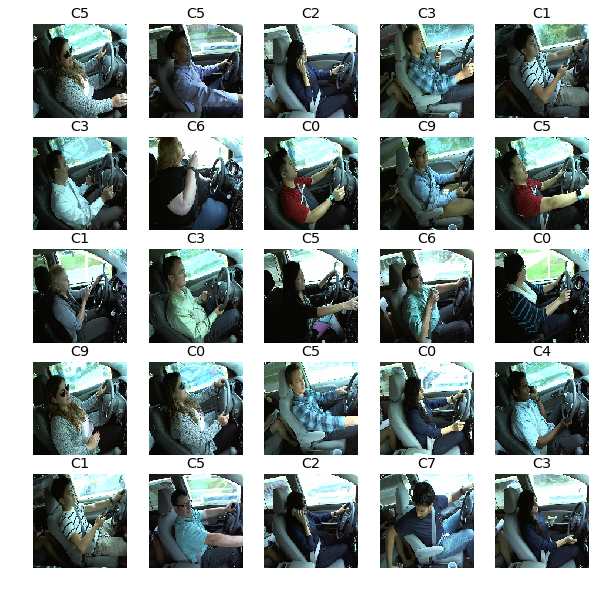

In [18]:
# Exibe imagens do primeiro lote de imagens de treinamento
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Definindo o Modelo

In [19]:
def create_model(train_base_model=False):
    """Cria o modelo e todas as suas camadas"""
    IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

    # Camada base de convolução, MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE, include_top=False,
        weights='imagenet')
    
    # Define se a classe será treinada junto com as outras camadas
    base_model.trainable = train_base_model

    # Define a camada que converterá a saída das camadas de convolução
    # em um vetor de uma dimensão
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    # Definindo a camada de previsão, fully connected layer
    prediction_layer = tf.keras.Sequential([
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='softmax')
    ]) 
    
    # Ligando as camadas do modelo
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      prediction_layer
    ])
    
    return model

In [20]:
def compile_model(model, learning_rate=0.001):
    """Definição das configurações de treinamento do modelo"""
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [21]:
# Definindo o modelo
with strategy.scope():
    train_ds = train_data_gen
    valid_ds = validation_data_gen
    test_ds = test_data_gen
    if tpu:
        train_ds = tf.data.TFRecordDataset.from_generator(lambda: train_data_gen, output_types=(tf.float32, tf.float32), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, len(CLASS_NAMES)]))
        valid_ds = tf.data.TFRecordDataset.from_generator(lambda: validation_data_gen, output_types=(tf.float32, tf.float32), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, len(CLASS_NAMES)]))
        test_ds = tf.data.TFRecordDataset.from_generator(lambda: test_data_gen, output_types=(tf.float32, ), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3],))
        
    model = create_model()
    compile_model(model)

9412608/9406464 [==============================] - 1s 0us/step


In [22]:
# Exibe os detalhes do modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                362122    
Total params: 2,620,106
Trainable params: 362,122
Non-trainable params: 2,257,984
_________________________________________________________________


## Avaliando acurácia inicial do Modelo

In [23]:
loss0,accuracy0 = model.evaluate(valid_ds, steps=None)

18/18 [==============================] - 34s 2s/step - loss: 2.3080 - accuracy: 0.0832


## Treinando o Modelo

In [24]:
epochs = 15
history_1 = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Train for 71 steps, validate for 18 steps
Epoch 1/15
71/71 [==============================] - 150s 2s/step - loss: 2.1887 - accuracy: 0.2610 - val_loss: 2.2870 - val_accuracy: 0.1491
Epoch 2/15
71/71 [==============================] - 117s 2s/step - loss: 1.9542 - accuracy: 0.5172 - val_loss: 2.1983 - val_accuracy: 0.2515
Epoch 3/15
71/71 [==============================] - 116s 2s/step - loss: 1.8353 - accuracy: 0.6368 - val_loss: 2.2308 - val_accuracy: 0.2238
Epoch 4/15
71/71 [==============================] - 115s 2s/step - loss: 1.7620 - accuracy: 0.7062 - val_loss: 2.2532 - val_accuracy: 0.2015
Epoch 5/15
71/71 [==============================] - 116s 2s/step - loss: 1.7256 - accuracy: 0.7435 - val_loss: 2.2271 - val_accuracy: 0.2245
Epoch 6/15
71/71 [==============================] - 115s 2s/step - loss: 1.7008 - accuracy: 0.7656 - val_loss: 2.2122 - val_accuracy: 0.2374
Epoch 7/15
71/71 [==============================] - 115s 2s/step - loss: 1.6719 - accuracy: 0.7950 - val_loss: 2

In [25]:
epochs = 10

compile_model(model, learning_rate=0.0001)
history_2 = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Train for 71 steps, validate for 18 steps
Epoch 1/10
71/71 [==============================] - 121s 2s/step - loss: 1.5706 - accuracy: 0.8961 - val_loss: 2.1716 - val_accuracy: 0.2839
Epoch 2/10
71/71 [==============================] - 117s 2s/step - loss: 1.5653 - accuracy: 0.9003 - val_loss: 2.1786 - val_accuracy: 0.2743
Epoch 3/10
71/71 [==============================] - 116s 2s/step - loss: 1.5625 - accuracy: 0.9024 - val_loss: 2.1711 - val_accuracy: 0.2807
Epoch 4/10
71/71 [==============================] - 116s 2s/step - loss: 1.5617 - accuracy: 0.9019 - val_loss: 2.1755 - val_accuracy: 0.2790
Epoch 5/10
71/71 [==============================] - 154s 2s/step - loss: 1.5624 - accuracy: 0.9018 - val_loss: 2.1846 - val_accuracy: 0.2698
Epoch 6/10
71/71 [==============================] - 117s 2s/step - loss: 1.5584 - accuracy: 0.9056 - val_loss: 2.1923 - val_accuracy: 0.2624
Epoch 7/10
71/71 [==============================] - 118s 2s/step - loss: 1.5566 - accuracy: 0.9099 - val_loss: 2

In [26]:
epochs = 30

model.layers[0].trainable = True
compile_model(model, learning_rate=0.0001)
history_3 = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Train for 71 steps, validate for 18 steps
Epoch 1/30
71/71 [==============================] - 137s 2s/step - loss: 1.5377 - accuracy: 0.9247 - val_loss: 2.0579 - val_accuracy: 0.3952
Epoch 2/30
71/71 [==============================] - 130s 2s/step - loss: 1.4988 - accuracy: 0.9630 - val_loss: 2.0469 - val_accuracy: 0.4075
Epoch 3/30
71/71 [==============================] - 130s 2s/step - loss: 1.4845 - accuracy: 0.9770 - val_loss: 1.9287 - val_accuracy: 0.5298
Epoch 4/30
71/71 [==============================] - 130s 2s/step - loss: 1.4797 - accuracy: 0.9814 - val_loss: 1.7503 - val_accuracy: 0.7126
Epoch 5/30
71/71 [==============================] - 131s 2s/step - loss: 1.4780 - accuracy: 0.9836 - val_loss: 1.7123 - val_accuracy: 0.7494
Epoch 6/30
71/71 [==============================] - 131s 2s/step - loss: 1.4727 - accuracy: 0.9892 - val_loss: 1.7451 - val_accuracy: 0.7137
Epoch 7/30
71/71 [==============================] - 131s 2s/step - loss: 1.4728 - accuracy: 0.9882 - val_loss: 1

## Salvando o Modelo

In [27]:
model.save(os.path.join(root_output_local, 'model_v2.h5'))

## Carregando o Modelo

In [28]:
new_model = tf.keras.models.load_model(os.path.join(root_output_local, 'model_v2.h5'))

## Avaliando o modelo treinado

In [29]:
loss1, accuracy1 = new_model.evaluate(valid_ds, steps=None)

18/18 [==============================] - 24s 1s/step - loss: 1.4732 - accuracy: 0.9879


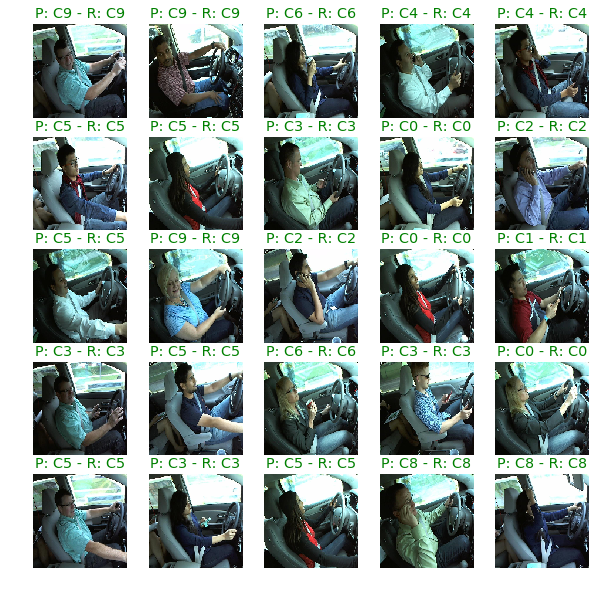

In [30]:
image_batch, label_batch = next(valid_ds)
predicted_labels = new_model.predict_classes(image_batch)
show_batch(image_batch, label_batch, predicted_labels)

### Avaliando desempenho em relação a cada classe

In [31]:
predict_classes = new_model.predict_classes(validation_no_shuffe, batch_size=None)

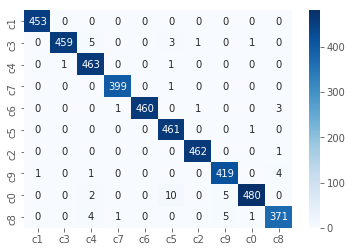

In [32]:
sns.heatmap(tf.math.confusion_matrix(validation_no_shuffe.classes, predict_classes), annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES);

In [35]:
result = pd.DataFrame(
    {'real_label': map(lambda x: CLASS_NAMES[x], validation_no_shuffe.classes), 
     'prediction': map(lambda x: CLASS_NAMES[x], predict_classes), 
     'correct_prediction': validation_no_shuffe.classes == predict_classes})
result.to_parquet('validation_result.parquet')
result.head()

,real_label,prediction,correct_prediction
0,c1,c1,True
1,c1,c1,True
2,c1,c1,True
3,c1,c1,True
4,c1,c1,True


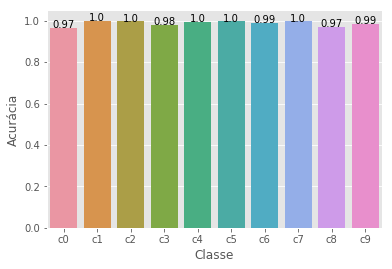

In [36]:
acc_per_class = result.groupby('real_label').mean().reset_index()
ax = sns.barplot(x="real_label", y="correct_prediction", data=acc_per_class);
ax.set_xlabel('Classe')
ax.set_ylabel('Acurácia')

for index, row in acc_per_class.iterrows():
    ax.text(row.name,row.correct_prediction, round(row.correct_prediction,2), color='black', ha="center")

### Avaliando desempenho nos dados de teste (visualmente)

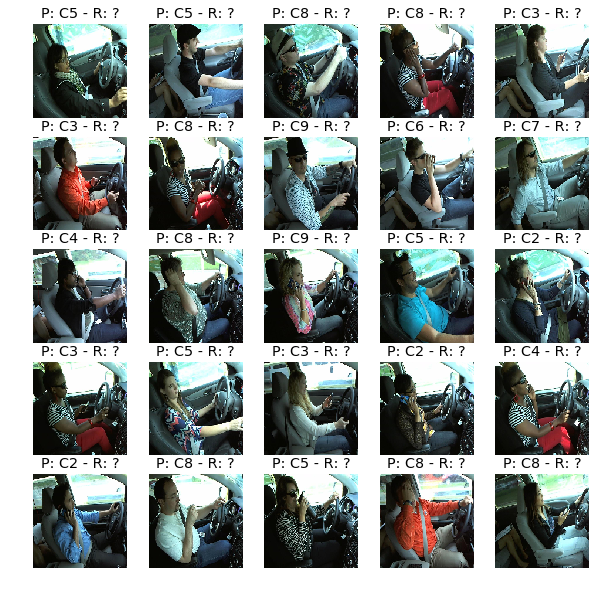

In [37]:
image_batch = next(test_ds)
predicted_labels = new_model.predict_classes(image_batch)
show_batch(image_batch, predict_labels=predicted_labels)

## Analisando a performance durante o treinamento

In [38]:
histories = [history_1, history_2, history_3]

history_df = pd.concat([pd.DataFrame(h.history) for h in histories], ignore_index=True)

### Salvando historico de treinamento

In [39]:
history_df.to_parquet(os.path.join(root_output_local, 'history.parquet'))

### Carregando histórico de treinamento

In [40]:
history_df = pd.read_parquet(os.path.join(root_output_local, 'history.parquet'))

history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.190010,0.261049,2.287008,0.149074
1,1.953551,0.517193,2.198265,0.251506
2,1.835871,0.636850,2.230811,0.223834
3,1.763766,0.706236,2.253221,0.201518
4,1.726857,0.743465,2.227143,0.224503


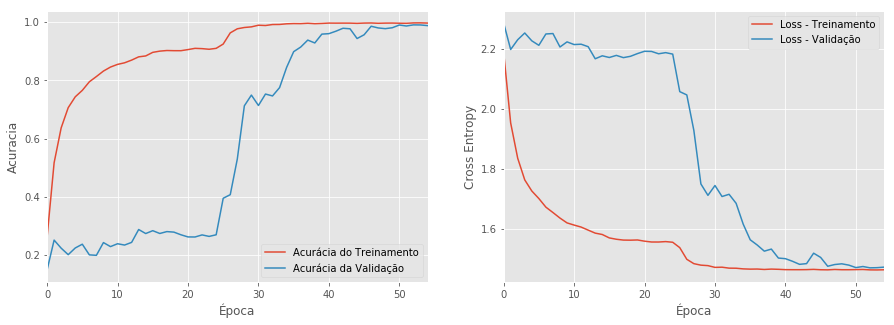

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

history_df.accuracy.plot(ax=ax1, label='Acurácia do Treinamento')
history_df.val_accuracy.plot(ax=ax1, label='Acurácia da Validação')
ax1.set_xlabel('Época')
ax1.set_ylabel('Acuracia')
ax1.legend()

history_df.loss.plot(ax=ax2, label='Loss - Treinamento')
history_df.val_loss.plot(ax=ax2, label='Loss - Validação')
ax2.set_xlabel('Época')
ax2.set_ylabel('Cross Entropy')
ax2.legend()

fig.show()

## Criando arquivo de submissão do Kaggle

In [42]:
proba_test = new_model.predict_proba(test_data_gen, batch_size=None)

In [43]:
output_kaggle = pd.DataFrame(proba_test, columns=CLASS_NAMES, index=test_data_gen.filenames)

output_kaggle = output_kaggle[output_kaggle.columns.sort_values()].reset_index().rename(columns={'index': 'img'})

output_kaggle['img'] = output_kaggle.img.str.split('/').apply(lambda x: x[-1])

In [44]:
output_kaggle.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,2.367109e-19,1.340611e-22,4.232094e-20,1.914109e-18,3.803695e-20,1.000000e+00,1.075674e-24,5.460701e-25,4.898436e-24,3.943202e-17
1,img_10.jpg,1.500610e-16,4.742197e-28,4.946905e-23,1.136864e-22,6.158148e-22,1.000000e+00,1.560942e-23,1.695486e-22,2.379210e-21,1.081542e-24
2,img_100.jpg,4.412814e-03,6.385273e-08,4.255400e-08,3.487452e-02,5.262514e-05,3.080407e-05,1.132164e-07,4.755742e-08,9.606276e-01,1.423081e-06
3,img_1000.jpg,0.000000e+00,0.000000e+00,6.055255e-37,0.000000e+00,2.964571e-35,2.334081e-37,1.239370e-38,8.634072e-37,1.000000e+00,1.228257e-32
4,img_100000.jpg,5.517708e-14,1.952214e-16,1.646848e-15,1.000000e+00,1.594532e-10,1.206863e-11,2.187709e-17,1.866323e-22,6.721985e-16,1.959391e-16


In [45]:
output_kaggle.to_csv('submission.csv', index=False)